In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn
from torch.nn import functional as F
import torch.utils.data
import torchvision.utils
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print('Device:',device)
print('Pytorch:',torch.__version__)
if torch.cuda.is_available() is True:
    print(torch.cuda.get_device_name(0))


Device: cpu
Pytorch: 2.4.1+cu121



# Creating the dataset

In [2]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

In [3]:
# Configuration
kwargs = {'num_workers': 1, 'pin_memory': True} if device=="cuda" else {}
batch_size = 256

In [4]:
# Dataset class

class Dataset(torch.utils.data.Dataset):
  'Characterizes a dataset for PyTorch'
  def __init__(self, input_data, output_data, total_samples=1000, spatial_size=10):
        'Initialization'
        self.input_data = torch.from_numpy(input_data).float()
        self.output_data = torch.from_numpy(output_data).float()
        self.total_samples = total_samples
        self.spatial_size = spatial_size

  def __len__(self):
        'Denotes the total number of samples'
        return self.total_samples

  def __getitem__(self, index):
        'Generates one sample of data'
        
        # Random crop in x,y dimensions:
        y_ = np.random.randint(low=0,high=self.input_data.shape[0]-self.spatial_size)
        x_ = np.random.randint(low=0,high=self.input_data.shape[1]-self.spatial_size)
        
        x = self.input_data[y_:y_+self.spatial_size,x_:x_+self.spatial_size,:]
        y = self.output_data[y_:y_+self.spatial_size,x_:x_+self.spatial_size,:]
        
        # (batch_size, channels, height, width)
        return x.T, y.T



In [5]:
# Definition of the convolutional neural network:
class convnet(nn.Module):
    'Neural network definition'
    def __init__(self, input_size, output_size, kernel_size=3, stride=1, padding=0):
        super(convnet, self).__init__()
        
        self.kernel_size = kernel_size
        self.conv1 = nn.Conv2d(input_size, 128, kernel_size=kernel_size, stride=stride, padding=padding)
        self.conv2 = nn.Conv2d(128, 64,kernel_size=kernel_size, stride=stride, padding=padding)
        self.conv3 = nn.Conv2d(64, 32, kernel_size=kernel_size, stride=stride, padding=padding)
        self.conv4 = nn.Conv2d(32, 16, kernel_size=kernel_size, stride=stride, padding=padding)
        self.conv5 = nn.Conv2d(16, output_size, kernel_size=kernel_size, stride=stride, padding=padding)
        
        # ReflectionPad2d for the 3x3 kernel:
        self.refpad = nn.ReflectionPad2d(1)
        self.refpad2 = nn.ReflectionPad2d(2)
        self.refpad3 = nn.ReflectionPad2d(3)
        
        
    def forward(self, x):
        'Forward function'
        
        if self.kernel_size == 1:
            x = F.relu(self.conv1(x))
            x = F.relu(self.conv2(x))
            x = F.relu(self.conv3(x))
            x = F.relu(self.conv4(x))
            return self.conv5(x)
   
        if self.kernel_size == 3:
            x = F.relu(self.conv1(self.refpad(x)))
            x = F.relu(self.conv2(self.refpad(x)))
            x = F.relu(self.conv3(self.refpad(x)))
            x = F.relu(self.conv4(self.refpad(x)))
            out = self.conv5(self.refpad(x))   
            return out  
        
        if self.kernel_size == 5:
            x = F.relu(self.conv1(self.refpad2(x)))
            x = F.relu(self.conv2(self.refpad2(x)))
            x = F.relu(self.conv3(self.refpad2(x)))
            x = F.relu(self.conv4(self.refpad2(x)))
            out = self.conv5(self.refpad2(x))   
            return out  
        
        if self.kernel_size == 7:
            x = F.relu(self.conv1(self.refpad3(x)))
            x = F.relu(self.conv2(self.refpad3(x)))
            x = F.relu(self.conv3(self.refpad3(x)))
            x = F.relu(self.conv4(self.refpad3(x)))
            out = self.conv5(self.refpad3(x))   
            return out 
        

In [6]:
from astropy.io import fits

In [7]:
#from google.colab import drive
#drive.mount('/content/gdrive/')

In [8]:
intensity = fits.open("/home/milic/data/muram_from_rebecca/disk_center/og/qs_ph_disk_center_synth.fits")[0].data[:,:,[0,3],:]


In [9]:
intensity = intensity.reshape(1536,1536,402)

In [10]:
atmos = fits.open("/home/milic/data/muram_from_rebecca/disk_center/atmos/qs_ph_disk_center.fits")[0].data

In [11]:
atmos.shape

(11, 71, 1536, 1536)

In [12]:
atmos = atmos.transpose(0,3,2,1)

In [13]:
height = atmos[8]

In [14]:
height -= np.mean(height[:,:,15])

In [15]:
output = height[:,:,[15,25,35]]

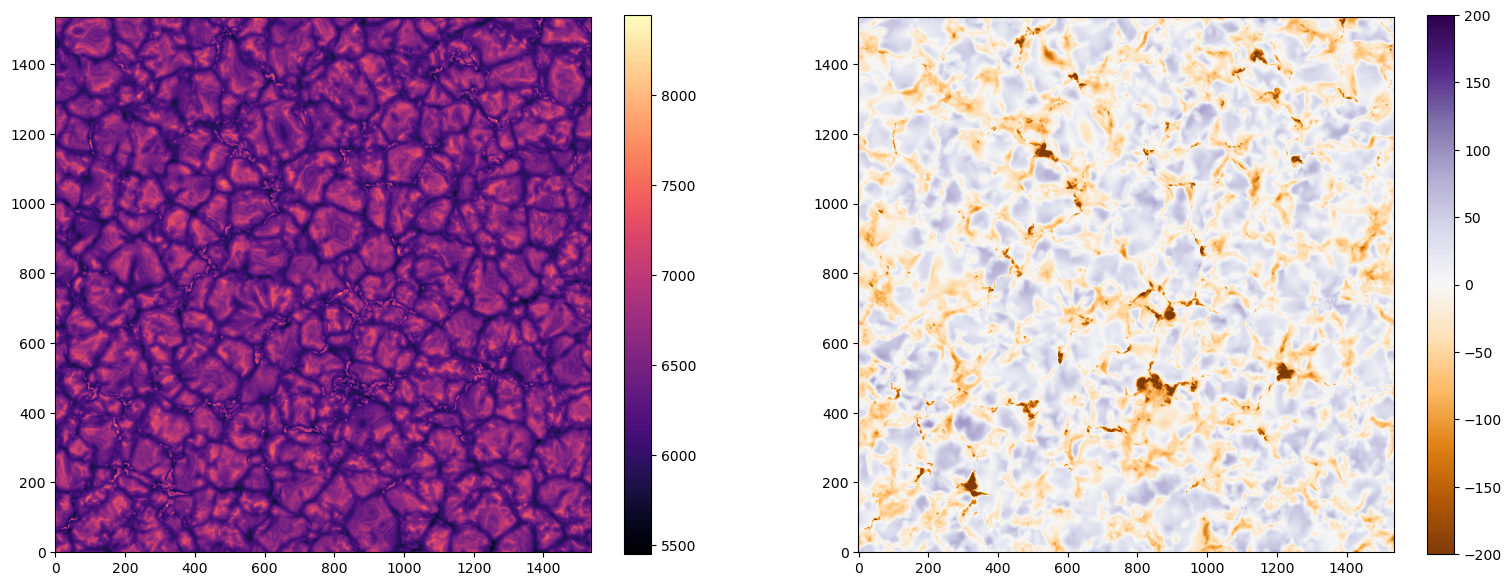

In [16]:

plt.figure(figsize=[19,7])
plt.subplot(121)
plt.imshow(atmos[1,:,:,15].T,cmap = 'magma',origin='lower')
plt.colorbar()
plt.subplot(122)
plt.imshow(output[:,:,0].T,cmap = 'PuOr',origin='lower',vmin=-200,vmax=200)
plt.colorbar()

In [17]:
output.shape

(1536, 1536, 3)

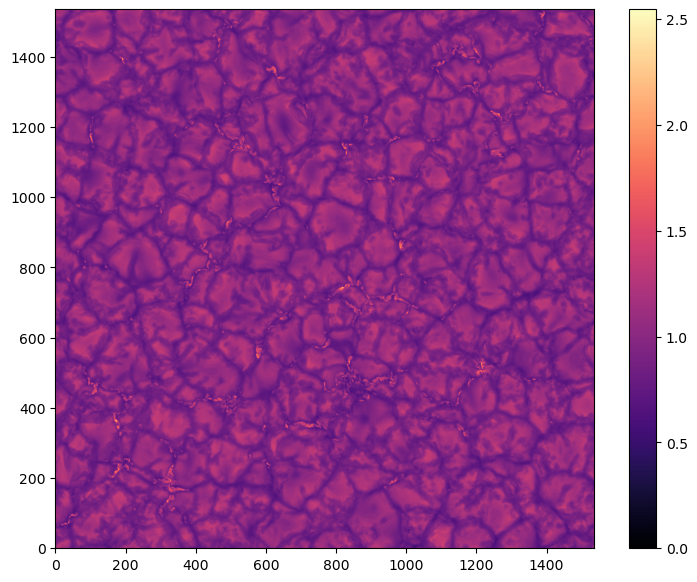

In [18]:
plt.figure(figsize=[9,7])
plt.imshow(intensity[:,:,25].T,cmap = 'magma',origin='lower')
plt.colorbar()

In [19]:
means = np.mean(output,axis=(0,1))

In [20]:
stds = np.std(output,axis=(0,1))

In [21]:
means

array([-2.4880923e-04,  1.5733423e+02,  3.0401321e+02], dtype=float32)

In [22]:
stds

array([37.714447, 34.56478 , 39.96715 ], dtype=float32)

In [23]:
output_norm = (output - means[None,None,:]) / stds[None,None,:]

In [24]:
imeans = np.mean(intensity[:,:,:201])

In [25]:
istds = np.std(intensity)

In [26]:
print(imeans, istds)

0.8992052563405541 0.487550651470603


In [27]:
input_norm = (intensity[:,:,:])/istds

In [28]:
input_norm.shape

(1536, 1536, 402)

In [29]:
input_norm[:,:,:201] -= imeans / istds 

In [30]:
input_norm[:,:,201:] *= 3.0

In [31]:
del(intensity)

In [32]:
# Generators
training_set = Dataset(input_norm, output_norm[:,:,:], total_samples=5000, spatial_size=16)
train_loader = torch.utils.data.DataLoader(training_set,batch_size=batch_size,shuffle=True, **kwargs)

In [33]:
nw = 402
nz = 3

In [34]:
# 2D convolution:
learning_rate = 5e-4
model = convnet(input_size=nw, output_size=nz,kernel_size=3).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
num_epochs = 100
myloss = nn.MSELoss()

model.train()


convnet(
  (conv1): Conv2d(402, 128, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv4): Conv2d(32, 16, kernel_size=(3, 3), stride=(1, 1))
  (conv5): Conv2d(16, 3, kernel_size=(3, 3), stride=(1, 1))
  (refpad): ReflectionPad2d((1, 1, 1, 1))
  (refpad2): ReflectionPad2d((2, 2, 2, 2))
  (refpad3): ReflectionPad2d((3, 3, 3, 3))
)

In [35]:
losses = np.zeros(num_epochs)

for epoch in range(0, num_epochs):
    for batch_idx, (data, params) in enumerate(train_loader):
        data = data.to(device)
        params = params.to(device)
        optimizer.zero_grad()

        out = model(data)
        loss = myloss(out,params)

        loss.backward()
        optimizer.step()
        
        losses[epoch] = loss.item()
    print("Iteration ", epoch, "loss: ", loss)

  

/tmp/ipykernel_18097/1234534402.py:27: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3571.)
  return x.T, y.T


Iteration  0 loss:  tensor(0.4897, device='cuda:0', grad_fn=<MseLossBackward0>)
Iteration  1 loss:  tensor(0.3879, device='cuda:0', grad_fn=<MseLossBackward0>)
Iteration  2 loss:  tensor(0.3954, device='cuda:0', grad_fn=<MseLossBackward0>)
Iteration  3 loss:  tensor(0.4199, device='cuda:0', grad_fn=<MseLossBackward0>)
Iteration  4 loss:  tensor(0.4228, device='cuda:0', grad_fn=<MseLossBackward0>)
Iteration  5 loss:  tensor(0.3810, device='cuda:0', grad_fn=<MseLossBackward0>)
Iteration  6 loss:  tensor(0.4585, device='cuda:0', grad_fn=<MseLossBackward0>)
Iteration  7 loss:  tensor(0.3665, device='cuda:0', grad_fn=<MseLossBackward0>)
Iteration  8 loss:  tensor(0.3342, device='cuda:0', grad_fn=<MseLossBackward0>)
Iteration  9 loss:  tensor(0.3872, device='cuda:0', grad_fn=<MseLossBackward0>)
Iteration  10 loss:  tensor(0.3918, device='cuda:0', grad_fn=<MseLossBackward0>)
Iteration  11 loss:  tensor(0.3256, device='cuda:0', grad_fn=<MseLossBackward0>)
Iteration  12 loss:  tensor(0.3778, de

In [36]:
x_start_test = 100
NX_test = 500
y_start_test = 900
NY_test = 500
test = input_norm[x_start_test:x_start_test+NX_test, y_start_test:y_start_test+NY_test,:]

In [37]:
test.shape

(500, 500, 402)

In [38]:
test = test.transpose(2,0,1)
test = test.reshape(1,402,NX_test,NY_test)

In [39]:
output_test = model.forward(torch.from_numpy(test).float().to(device))
output_test = output_test.to('cpu')

In [40]:
output_test.shape

torch.Size([1, 3, 500, 500])

In [41]:
output_heights = output_test.detach().numpy()

In [42]:
output_heights = output_heights.reshape(3,NX_test,NY_test)
output_heights = output_heights.transpose(1,2,0)

In [43]:
output_heights *= stds[None,None,:]
output_heights += means[None, None, :]

In [44]:
from scipy.stats import pearsonr

Text(0.5, 1.0, '0.8451083727123364')

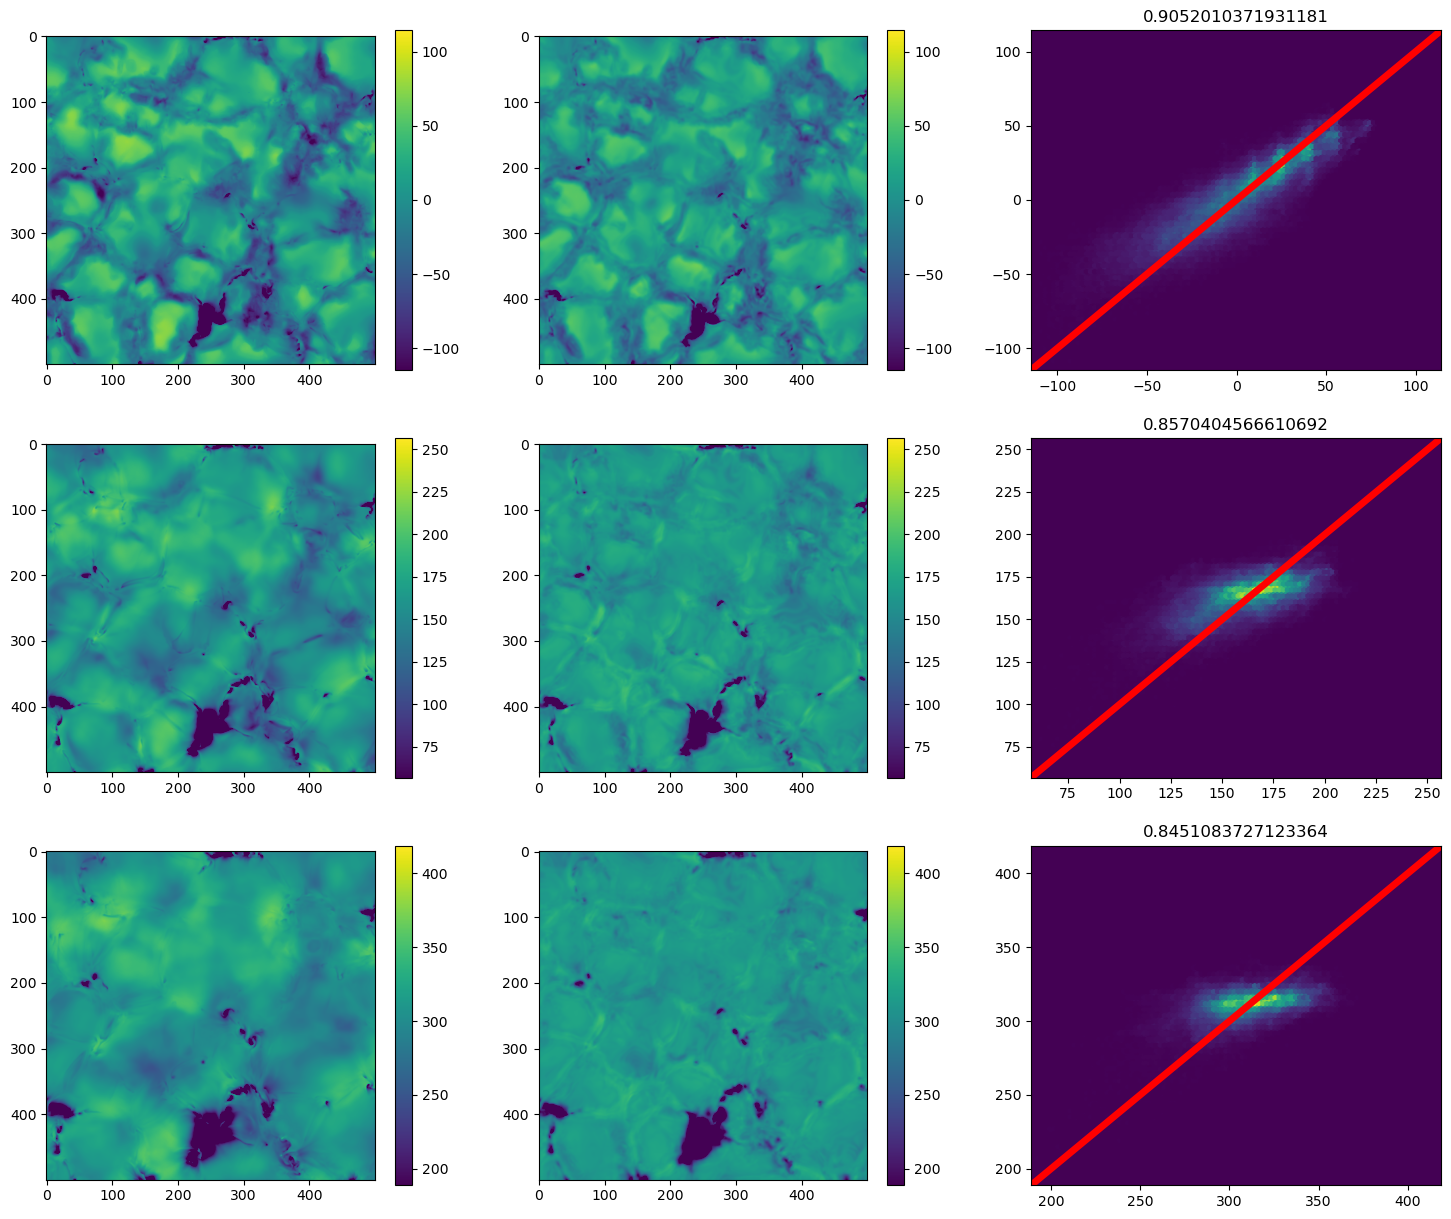

In [45]:
plt.figure(figsize=[18,15])

plt.subplot(331)
first = height[x_start_test:x_start_test+NX_test, y_start_test:y_start_test+NY_test,15]
second = output_heights[:,:,0]
m = np.mean(first)
s = np.std(first)
plt.imshow(first, vmin=m-3*s,vmax=m+3*s)
plt.colorbar()
plt.subplot(332)
plt.imshow(second, vmin=m-3*s,vmax=m+3*s)
plt.colorbar()

plt.subplot(333)
#plt.scatter(first.flatten(),second.flatten(),alpha=0.02)
plt.hexbin(first.flatten(),second.flatten(),extent=[m-3*s,m+3*s,m-3*s,m+3*s])
plt.plot([m-3*s,m+3*s],[m-3*s,m+3*s],color='red', linewidth=5)
plt.ylim([m-3*s,m+3*s])
plt.xlim([m-3*s,m+3*s])
plt.title(str(pearsonr(first.flatten(),second.flatten())[0]))

plt.subplot(334)
first = height[x_start_test:x_start_test+NX_test, y_start_test:y_start_test+NY_test,25]
second = output_heights[:,:,1]
m = np.mean(first)
s = np.std(first)
plt.imshow(first, vmin=m-3*s,vmax=m+3*s)
plt.colorbar()
plt.subplot(335)
plt.imshow(second, vmin=m-3*s,vmax=m+3*s)
plt.colorbar()

plt.subplot(336)
#plt.scatter(first.flatten(),second.flatten(),alpha=0.02)
plt.hexbin(first.flatten(),second.flatten(),extent=[m-3*s,m+3*s,m-3*s,m+3*s])
plt.plot([m-3*s,m+3*s],[m-3*s,m+3*s],color='red', linewidth=5)
plt.ylim([m-3*s,m+3*s])
plt.xlim([m-3*s,m+3*s])
plt.title(str(pearsonr(first.flatten(),second.flatten())[0]))


plt.subplot(337)
first = height[x_start_test:x_start_test+NX_test, y_start_test:y_start_test+NY_test,35]
second = output_heights[:,:,2]
m = np.mean(first)
s = np.std(first)
plt.imshow(first, vmin=m-3*s,vmax=m+3*s)
plt.colorbar()
plt.subplot(338)
plt.imshow(second, vmin=m-3*s,vmax=m+3*s)
plt.colorbar()

plt.subplot(339)
#plt.scatter(first.flatten(),second.flatten(),alpha=0.02)
plt.hexbin(first.flatten(),second.flatten(),extent=[m-3*s,m+3*s,m-3*s,m+3*s])
plt.plot([m-3*s,m+3*s],[m-3*s,m+3*s],color='red', linewidth=5)
plt.ylim([m-3*s,m+3*s])
plt.xlim([m-3*s,m+3*s])
plt.title(str(pearsonr(first.flatten(),second.flatten())[0]))
